# Machine Learning project
### Part 1: Data preprocessing
##### Machine Learning - MEBDS, UNAV

*Authors:* Daniel Marchán, Francisco Álvarez, Yijie Hsieh and Jaime Fanjul.

In this section we curate, reformat, clean and impute the data in order to be used in the creation of the recommender system models.<br>

## Índice:

1. [Load raw data](#1)<br>
2. [Visualize data](#2)
2. [Data Cleaning](#3)
3. [Imputation](#4)
4. [Correct Format](#5)
5. [Save imputed data](#6)

##### Imports needed

In [ ]:
#Manejo de data frames
import pandas as pd
# Procesamiento matemático
import numpy as np
# Gráficas
import matplotlib.pyplot as plt
# Métodos de imputacion
import sklearn.impute as si
# Visualización de datos faltantes
import missingno as msno
# Control de datos faltantes categoricos
import sklearn.preprocessing as sp
# Gráfico de cajas y bigotes
import seaborn as sns
from fancyimpute import KNN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import datetime
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from fancyimpute import KNN
import scipy
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load raw data <a id="1">
    
This is the data given by the professor:

In [ ]:
path = "/Users/danielmarchan/Documents/MasterBigData/MachineLearning/Recommender_System/rec_sys_alumnos.csv"

df = pd.read_csv(path)

/Users/danielmarchan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (5,9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 2. Visualize data<a id="2">

In [ ]:
num_vars = df.describe().drop('cod_persona', axis=1).columns 
cat_vars = df.drop(num_vars, axis=1).drop('cod_persona', axis=1).columns

<ipython-input-18-b743258eabb5>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


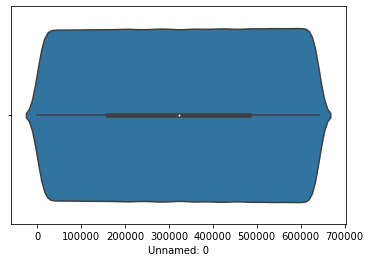

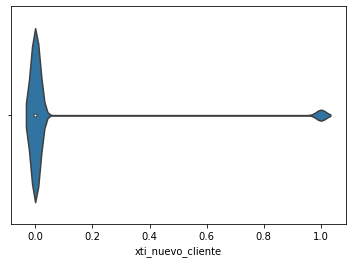

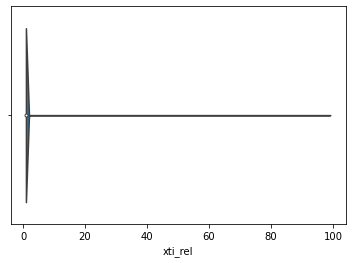

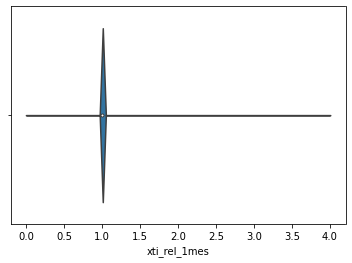

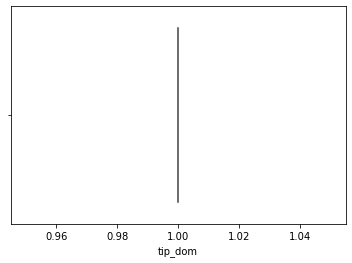

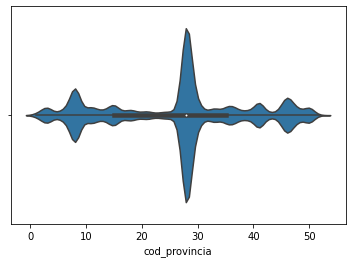

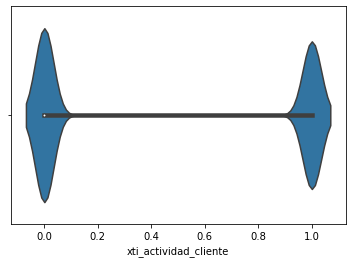

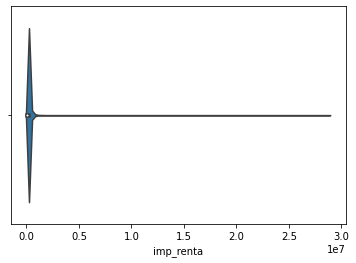

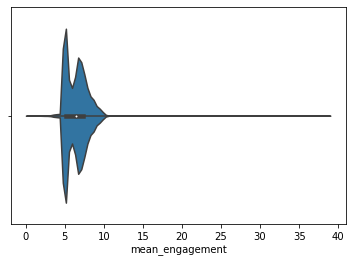

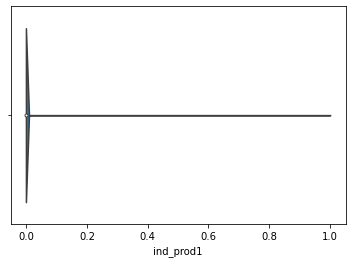

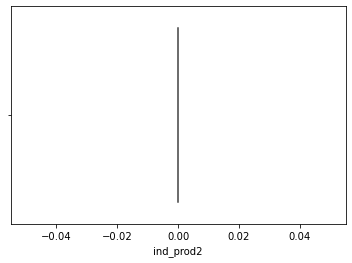

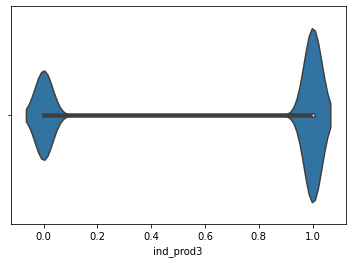

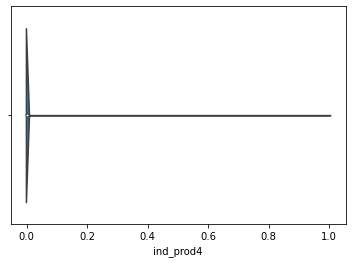

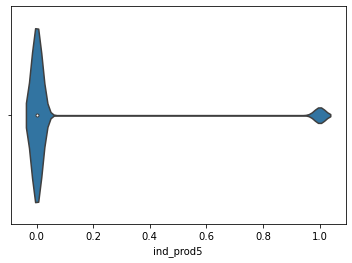

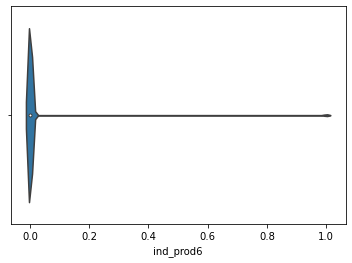

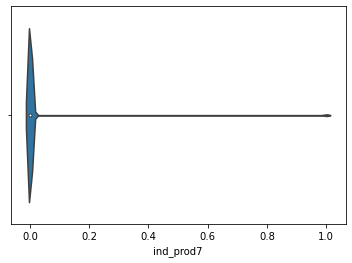

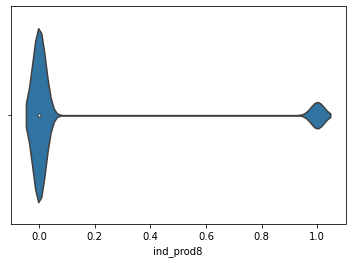

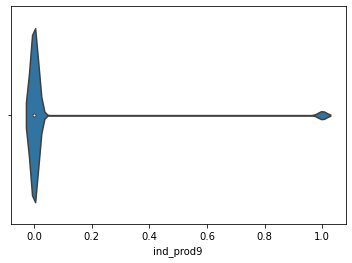

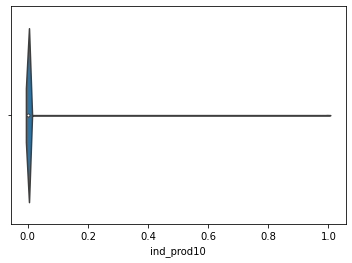

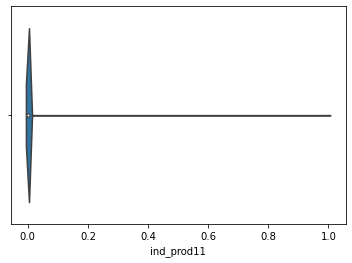

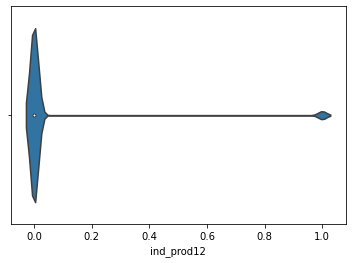

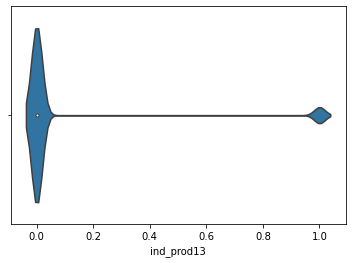

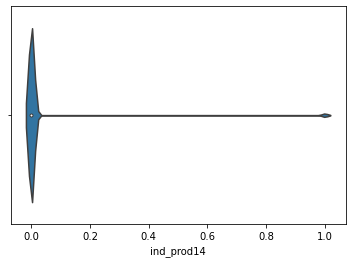

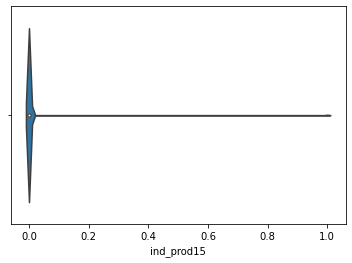

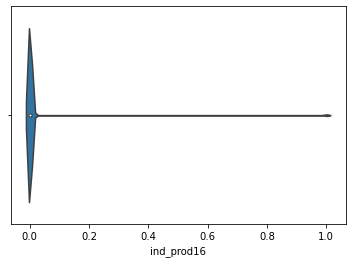

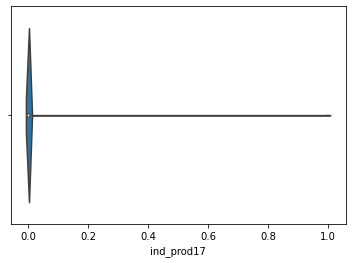

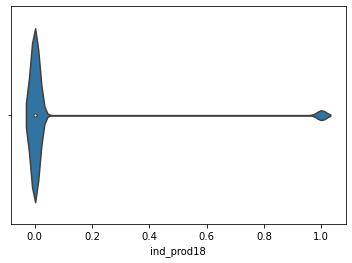

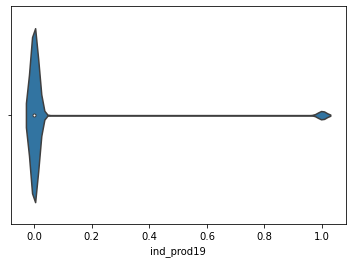

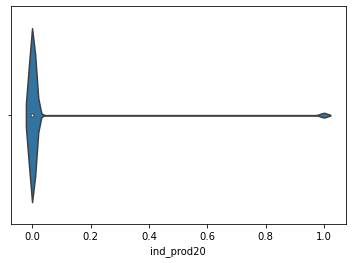

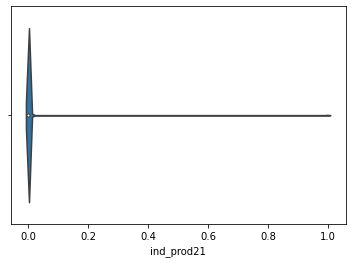

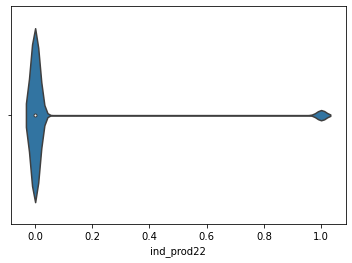

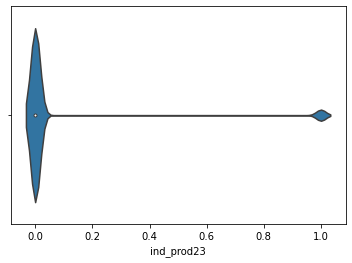

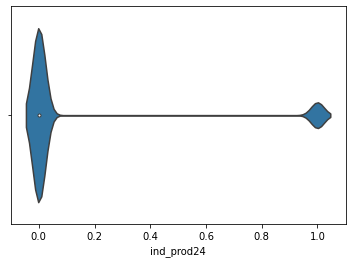

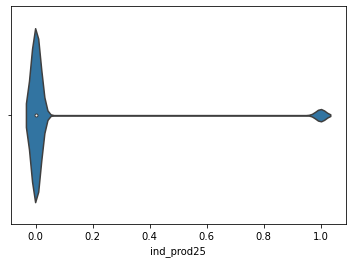

<Figure size 432x288 with 0 Axes>

In [ ]:
for var in num_vars: 
    sns.violinplot(x=df[var]) 
    plt.figure()

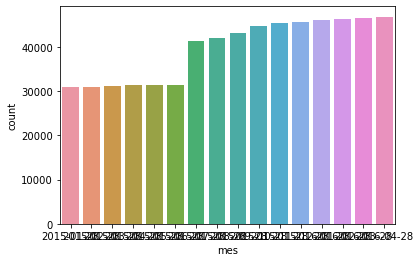

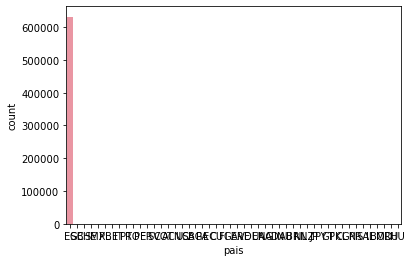

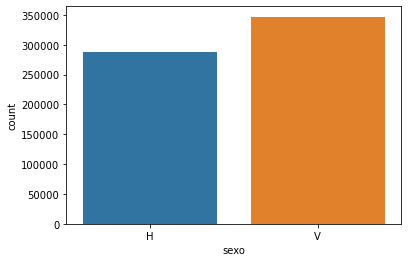

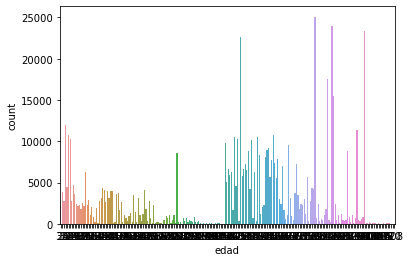

In [ ]:
for var in cat_vars: 
    sns.countplot(x=df[var]) 
    plt.figure()

## 3. Data cleaning <a id="3">


In [ ]:
# Ponemos de forma correcta los NaNs para la imputación
df_clean = df

#EDAD
#1. Corregir los formatos de los strings
df_clean['edad'] = df['edad'].str.strip()
#2. Ponerlos a un valor numerico para poderlos pasarlos a numerico 
df_clean['edad'] = df['edad'].str.replace('NA', '-1')
df_clean['edad'] = df['edad'].replace(np.nan, -1)
df_clean['edad'] = df['edad'].astype('int')
#3. Sustituir los valores numericos (ex: 0) a np.nan
df_clean['edad'] = df['edad'].replace(-1,np.nan)

#NUM_ANTIGUEDAD
df_clean['num_antiguedad'] = df['num_antiguedad'].str.strip()
df_clean['num_antiguedad'] = df['num_antiguedad'].str.replace('NA', '-1')
df_clean['num_antiguedad'] = df['num_antiguedad'].replace(np.nan, -1)
df_clean['num_antiguedad'] = df['num_antiguedad'].astype('int')
df_clean['num_antiguedad'] = df['num_antiguedad'].replace(-1,np.nan)

#XTI_REL
df_clean['xti_rel'] = df['xti_rel'].replace(99, 0)

#PROD22
df_clean['ind_prod22'] = df['ind_prod22'].fillna(0)
df_clean['ind_prod22'] = df_clean['ind_prod22'].astype('int')

#PROD23
df_clean['ind_prod23'] = df['ind_prod23'].fillna(0)
df_clean['ind_prod23'] = df_clean['ind_prod23'].astype('int')

### **Manejo de variables temporales**
#Esto lo que hace es quitar num_antiguedad que muchas veces está mal calculada,
#o no existe cuando mes y fecha1 si, por lo que la hemos calculado por nuestra
#cuenta y hemos creado otra variable, esto va aqui para no imputar un valor numerico
#que no hiciese falta 

#Treat small changes in the temporal manipulation
df_clean['mes'] = pd.to_datetime(df_clean['mes'],infer_datetime_format=True)
df_clean['fecha1'] = pd.to_datetime(df_clean['fecha1'],infer_datetime_format=True)

#Create variables
fecha_max = df_clean['fecha1'].max()
df_clean['antiguedad_meses'] = (((df_clean['mes'] - df_clean['fecha1'])).dt.days/30).astype('int')
df_clean['antiguedad_meses'][df_clean['antiguedad_meses']<0] = 0

# drop this value that was wrong computed
df_clean.drop("num_antiguedad", axis = 1, inplace=True)

## 4. Imputation<a id="4">

    We used three different models to impute the data: 
    - Smart imputer
    - Categorical imputer (most popular)
    - Numerical imputer (Random Forest imputation)

In [ ]:

def smart_imputer(df_clean):
    "Imputation using previous data of the same user, it fills customer data with previous entrances"
  
    list_cod_persona  = df_clean[df_clean['edad'].isna()].cod_persona.unique().tolist()

    #cojo las variables de interes que quiero imputar 
    variables2 = df_clean.drop(['cod_persona','ind_prod1', 'ind_prod2', 'ind_prod3',
    'ind_prod4', 'ind_prod5', 'ind_prod6', 'ind_prod7', 'ind_prod8',
    'ind_prod9', 'ind_prod10', 'ind_prod11', 'ind_prod12', 'ind_prod13',
    'ind_prod14', 'ind_prod15', 'ind_prod16', 'ind_prod17', 'ind_prod18',
    'ind_prod19', 'ind_prod20', 'ind_prod21', 'ind_prod22', 'ind_prod23',
    'ind_prod24', 'ind_prod25'], axis = 1).columns

    df_1 = df_clean.set_index('cod_persona') 
    df_clean_2 = df_clean.replace(np.nan, -1)

    for persona in list_cod_persona: 
    #print(persona)
        aux = df_clean_2[df_clean_2["cod_persona"] == persona] 
        for var in variables2:
        #print(var)
        aux2 = aux[var].unique()
        aux2 = aux2.tolist()
        #print(aux2)
        if -1 in aux2: 
        aux2.remove(-1)
        if len(aux2) >= 1:
            df_1.loc[persona, var] = aux2[0] 
            #print(aux2)
          
    df_1.reset_index(drop=False, inplace=True)
    df_1 = df_1.replace(-1,np.nan)

    #Save it if you want
    #df_1.to_csv('/content/drive/MyDrive/Colab Notebooks/MachineLearningProject/df_organized.csv', index = False)

    return df_1


#Categorical data Imputation
def categorical_imputer(df_clean):
    # Imputación categorica por the most frequent
    #(La lista de variables categoricas son las que mantienen NaNs)
    vars = ['sexo','tip_rel_1mes','des_canal','id_segmento'] 
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp.fit(df_clean[vars])
    data = imp.transform(df_clean[vars])

    df_clean[vars] = pd.DataFrame(data, index = df_clean.index, 
                                columns = df_clean[vars].columns)

    return df_clean


#Numerical data Imputation
def numerical_imputer(df_clean, by = "Random Forest"):
    #Imputacion numerica de solo las variables que hacen falta 
    #(esto se miró previamente para reducir las computación necesaria)
    num_vars = ['edad', 'imp_renta', 'cod_provincia', 'mean_engagement', 
                'xti_rel_1mes'] 

    if by == "Random Forest":
    # 1. definir el imputer
        imputer = IterativeImputer(estimator=RandomForestRegressor(), 
                                   n_nearest_features=None, 
                                   missing_values=np.nan, 
                                   imputation_order='ascending',
                                   initial_strategy='most_frequent')
    elif by == "KNN":
        imputer = KNN()
    else:
        print("No numerical imputer found")
        return none 

    # 2. fit el dataset
    imputer.fit(df_clean[num_vars])

    # 3. transformar el dataset
    data3 = imputer.transform(df_clean[num_vars])

    # 4. Pasarlo al datasett
    df_clean[num_vars] = pd.DataFrame(data3, index = df_clean.index, 
                                      columns = df_clean[num_vars].columns)
  
    return df_clean

#### Before imputation

In [ ]:
# En ninguno de estos datasets hay NAs
total = df_clean.isnull().sum().sort_values(ascending = False)
percent = (df_clean.isnull().sum()/df_clean.isnull().count()*100).sort_values(ascending = False)
mv2 = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje']).transpose()
mv2.head()

In [ ]:
msno.matrix(df_clean)

In [ ]:
# Quitamos las variables que no aportan nada al modelo
df_clean.drop("fec_ult_cli_1t", axis = 1, inplace=True)
df_clean.drop("Unnamed: 0", axis = 1, inplace=True)


#SMART IMPUTER
df_clean = smart_imputer(df_clean) #10 mins to execute aprox

#CATEGORICAL IMPUTER
df_clean = categorical_imputer(df_clean) #20 mins approx

#NUMERICAL IMPUTER
df_clean = numerical_imputer(df_clean, by = "Random Forest")#20 mins approx

#### After imputation

In [ ]:
# En ninguno de estos datasets hay NAs
total = df_clean.isnull().sum().sort_values(ascending = False)
percent = (df_clean.isnull().sum()/df_clean.isnull().count()*100).sort_values(ascending = False)
mv2 = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje']).transpose()
mv2.head()

In [ ]:
msno.matrix(df_clean)

## 5. *Correct Format*<a id="5">

In [ ]:
df_clean['edad'] = df_clean['edad'].astype('int')
df_clean['cod_provincia'] = df_clean['cod_provincia'].astype('int') 
df_clean['xti_nuevo_cliente'] = df_clean['xti_nuevo_cliente'].astype('int')
df_clean['num_antiguedad'] = df_clean['num_antiguedad'].astype('int')
df_clean['xti_rel'] = df_clean['xti_rel'].astype('int')
df_clean['xti_rel_1mes'] = df_clean['xti_rel_1mes'].astype('int')
df_clean['xti_actividad_cliente'] = df_clean['xti_actividad_cliente'].astype('int')
df_clean.drop("tip_dom", axis = 1, inplace=True) #Makes non sense since it is only taking one value and NaN

## 6. *Save data*<a id="6">

In [ ]:
df_clean.to_csv('df_complete2.csv')